Drive mount

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


global variable init

In [2]:
pwd_folder = '/content/drive/MyDrive/Colab_Notebooks/GAN/'

Import Pakage

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from PIL import Image
from tqdm import tqdm

from drive.MyDrive.Colab_Notebooks.GAN.model import GAN

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

Download MNIST Data

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((.5,), (.5,))])

train_dataset = datasets.MNIST(root = pwd_folder + "MNIST_data/train",
                               train = True,
                               download = True,
                               transform = transform)

test_dataset = datasets.MNIST(root = pwd_folder + "MNIST_data/test",
                              train = False,
                              download = True,
                              transform = transform)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

Hyper paramter Setting

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator     = GAN.Generator().to(device)
discriminator = GAN.Discriminator().to(device)

# generator.apply(GAN.weights_init)
# discriminator.apply(GAN.weights_init)

criterion = nn.BCELoss()

learning_rate = 2*1e-4
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)

epoches = 200

In [ ]:
d_loss_list = [] # train
g_loss_list = [] # train

d_performance_list = [] # test
g_performance_list = [] # test

for epoch in range(epoches):
  print("----Train----")
  for batch_i, (image, label) in enumerate(train_loader):
    batch_len = image.size()[0]

    real_label = torch.full((batch_len, 1), 1, dtype=torch.float32).to(device)
    fake_label = torch.full((batch_len, 1), 0, dtype=torch.float32).to(device)

    real_images = image.view(batch_len, -1).to(device)

    '''
        [train Generator]
    '''
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

    # Extract noise vector z (sampling normal distribution)
    z = torch.randn(batch_len, 128).to(device)
    fake_images = generator(z)

    # BCE loss : -{ylogx + (1-y)log(1-x)}
    # 기존 방법론에 의하면 log(1-D(G(z)))를 최소화 시켜야 하나, Non-Saturating game에 의해 log(D(G(z)))를 최대화 하는 것으로 쓸 수 있고,
    # 이를 최소화 Term으로 바꾸면 -log(D(G(z)))를 최소화 하는 것으로 쓸 수 있다.
    # BCE loss에서 y값에 1을 넣으면 -log(D(G(z)))가 도출되기 때문에 아래와 같이 쓸 수 있다.
    g_loss = criterion(discriminator(fake_images), real_label)
    g_loss.backward()
    g_optimizer.step()

    '''
        [train Discriminator]
    '''
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

    # Extract noise vector z (sampling normal distribution)
    z = torch.randn(batch_len, 128).to(device)
    fake_images = generator(z)

    # BCE loss : -{ylogx + (1-y)log(1-x)}
    # GAN의 목적함수는 log(D(x)) + log(1-D(G(z)))이며 두 항을 따로 보면 다음과 같다.
    # log(D(x))를 최대화        -> -log(D(x))를 최소화          ->
    # log(1-D(G(z)))를 최대화   -> -log(1-D(G(z)))를 최소화     ->

    fake_loss = criterion(discriminator(fake_images), fake_label)
    real_loss = criterion(discriminator(real_images), real_label)
    d_loss = (fake_loss + real_loss) / 2

    d_loss.backward()
    d_optimizer.step()

    d_loss_list.append(d_loss.item())
    g_loss_list.append(g_loss.item())

    if (batch_i + 1) % 200 == 0 or (batch_i + 1) == len(train_loader):
      print("Epoch [ {}/{} ]  Step [ {}/{} ]  d_loss : {:.5f}  g_loss : {:.5f}"\
            .format(epoches, epoch, batch_i+1, len(train_loader), d_loss.item(), g_loss.item()))

  print("----Test----")
  d_performance = 0.
  g_performance = 0.
  for batch_i, (image, label) in enumerate(test_loader):
    batch_len = image.size()[0]
    real_images = image.view(batch_len, -1).to(device)
    z = torch.randn(batch_len, 128).to(device)
    fake_images = generator(z)

    d_performance += discriminator(real_images).to('cpu').mean().item()
    g_performance += discriminator(fake_images).to('cpu').mean().item()

  d_performance /= len(test_loader)
  g_performance /= len(test_loader)

  d_performance_list.append(d_performance)
  g_performance_list.append(g_performance)
  print("Epoch [ {}/{} ] D performance {:.5f} G performance {:.5f}".format(epoches, epoch, d_performance, g_performance))

----Train----
Epoch [ 200/0 ]  Step [ 200/469 ]  d_loss : 0.22254  g_loss : 2.92644
Epoch [ 200/0 ]  Step [ 400/469 ]  d_loss : 0.00907  g_loss : 7.64597
Epoch [ 200/0 ]  Step [ 469/469 ]  d_loss : 0.00241  g_loss : 8.84151
----Test----
Epoch [ 200/0 ] D performance 0.99690 G performance 0.00070
----Train----
Epoch [ 200/1 ]  Step [ 200/469 ]  d_loss : 0.00227  g_loss : 11.47867
Epoch [ 200/1 ]  Step [ 400/469 ]  d_loss : 0.00129  g_loss : 10.20723
Epoch [ 200/1 ]  Step [ 469/469 ]  d_loss : 0.02399  g_loss : 11.79883
----Test----
Epoch [ 200/1 ] D performance 0.99887 G performance 0.01064
----Train----
Epoch [ 200/2 ]  Step [ 200/469 ]  d_loss : 0.02669  g_loss : 22.40806
Epoch [ 200/2 ]  Step [ 400/469 ]  d_loss : 0.08847  g_loss : 4.48144
Epoch [ 200/2 ]  Step [ 469/469 ]  d_loss : 0.12142  g_loss : 4.64062
----Test----
Epoch [ 200/2 ] D performance 0.94416 G performance 0.07901
----Train----
Epoch [ 200/3 ]  Step [ 200/469 ]  d_loss : 0.05835  g_loss : 6.53308
Epoch [ 200/3 ]  Step

Save model Weights

In [ ]:
# torch.save(generator.state_dict(), pwd_folder + 'weights/vanilla_GAN_generator.pt')
# torch.save(discriminator.state_dict(), pwd_folder + 'weights/vanilla_GAN_discriminator.pt')

Load model Weights

In [7]:
generator.load_state_dict(torch.load(pwd_folder+'weights/vanilla_GAN_generator.pt'))
discriminator.load_state_dict(torch.load(pwd_folder+'weights/vanilla_GAN_discriminator.pt'))

<All keys matched successfully>

D, G Performance

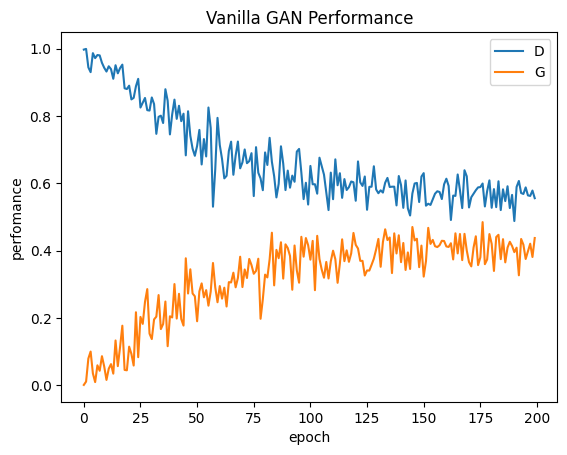

In [ ]:
plt.title("Vanilla GAN Performance")
plt.xlabel('epoch')
plt.ylabel('perfomance')
plt.plot(d_performance_list)
plt.plot(g_performance_list)
plt.legend(['D', 'G'])
plt.savefig(pwd_folder+'result/result1.png')
plt.show()

D, G Loss

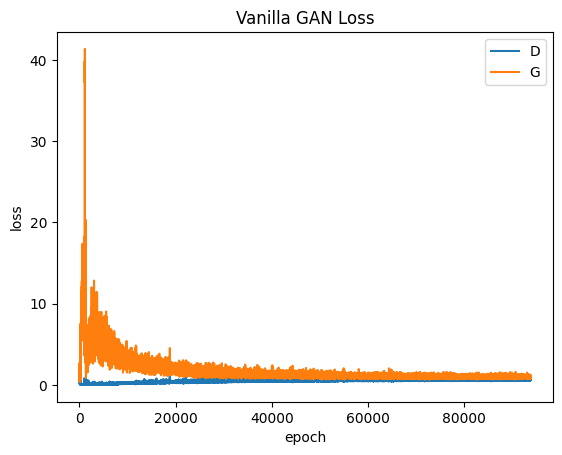

In [ ]:
plt.title("Vanilla GAN Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(d_loss_list)
plt.plot(g_loss_list)
plt.legend(['D', 'G'])
plt.savefig(pwd_folder+'result/result2.png')
plt.show()

Inference

In [ ]:
unnormalize = transforms.Normalize((-0.5 / 0.5), (1.0 / 0.5))


fake_img_full_list = []

for i in range(4):
  z = torch.randn(64, 128).to(device)
  fake_img = generator(z)
  fake_img = fake_img.view(fake_img.size()[0], 28, 28).detach().to('cpu')
  fake_img = unnormalize(fake_img)

  fake_img_full = torch.zeros(8*28, 8*28)

  i = 0
  for r in range(8):
    for c in range(8):
      fake_img[i]
      fake_img_full[r*28:(r+1)*28, c*28:(c+1)*28] = fake_img[i]
      i += 1
  fake_img_full = np.array(fake_img_full*255, dtype=np.uint8)
  fake_img_full_pil = Image.fromarray(fake_img_full)
  fake_img_full_list.append(fake_img_full_pil)

In [ ]:
im = fake_img_full_list[0]
im.save(pwd_folder+'result/out.gif', save_all=True, append_images=fake_img_full_list[1:],loop=0xff, duration=500)

Generated Image corresponding to change in z value

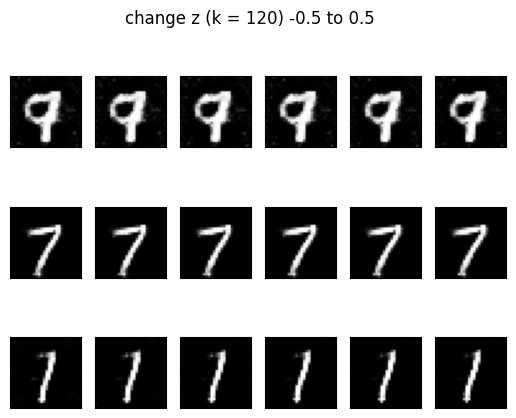

In [36]:
z_idx = 120
z = torch.randn(3, 128).to(device)

fig, axs = plt.subplots(3,6)
fig.suptitle("change z (k = {}) -0.5 to 0.5".format(z_idx))

for cnt, i in enumerate(range(-5, 5+1, 2)):
  variant = i/10
  z_ = z.clone()
  z_[:, z_idx] = torch.ones(3) * variant
  fake_img = generator(z_.to(device)).detach().to('cpu')
  fake_img = fake_img.view(3, 28, 28)

  for k in range(3):
    axs[k][cnt].imshow(fake_img[k], cmap='gray')
    axs[k][cnt].set_xticks([])
    axs[k][cnt].set_yticks([])

fig.savefig(pwd_folder+'result/change_k_{}.jpg'.format(z_idx))

In [49]:
change_z_list = [Image.open(path) for path in \
 [pwd_folder+'result/change_k_0.jpg', pwd_folder+'result/change_k_60.jpg', pwd_folder+'result/change_k_120.jpg']]

im = change_z_list[0]
im.save(pwd_folder+'result/out2.gif', save_all=True, append_images=change_z_list[1:],loop=0xff, duration=500)